In [4]:
import yfinance as yf
import pandas as pd
#from google.colab import drive
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LassoCV,Lasso
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.decomposition import PCA
import math
import statistics
import xgboost as xgb
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM
#drive.mount("/content/gdrive/")

In [10]:
def lagged_columns(df, groupby_column, columns_to_lag, num_lags):
    df_new = df.copy()
    for i in range(1, num_lags + 1):
        for col in columns_to_lag:
            lag_col_name = f"{col}_lag{i}"
            df_new[lag_col_name] = df_new.groupby(groupby_column)[col].shift(i)
    return df_new

In [13]:
with open('C:/Users/vindh/Downloads/stock_data.csv','r') as data:
    df_data = pd.read_csv(data)
df_data['Datetime'] =  pd.to_datetime(df_data['Datetime'])
df_model_data =  lagged_columns(df_data, 'stock', ['Close','Open','High','Low','Volume'],3)
with open('C:/Users/vindh/Downloads/stock_data_daily.csv','r') as data:
    df_data_daily = pd.read_csv(data)
df_data_daily.rename(columns={'Open':'daily_open','High':'daily_high','Low':'daily_low','Close':'daily_close','Volume':'daily_volume'},inplace=True)
df_data_daily['Date'] =  pd.to_datetime(df_data_daily['Date'])
df_data_daily['Date'] = df_data_daily['Date'] + pd.Timedelta(days=1)
df_model_data['Date'] =  df_model_data['Datetime'].dt.date
df_model_data['Date'] =  pd.to_datetime(df_model_data['Date'])
df_model_data=df_model_data.merge(df_data_daily,on=['Date', 'stock'])

In [15]:
df_model_data['time_period']=df_model_data['Datetime'].dt.strftime('%H%M')
df_model_data.head(3)

,Datetime,Open,High,Low,Close,Volume,stock,Close_lag1,Open_lag1,High_lag1,...,High_lag3,Low_lag3,Volume_lag3,Date,daily_open,daily_high,daily_low,daily_close,daily_volume,time_period
0,2022-12-14 09:30:00,95.199997,96.434998,95.180000,96.010002,1921870,GOOGL,NaN,NaN,NaN,...,NaN,NaN,NaN,2022-12-14,97.760002,99.529999,95.029999,95.629997,40593700,0930
1,2022-12-14 09:45:00,95.980003,96.080002,95.500000,95.820000,991742,GOOGL,96.010002,95.199997,96.434998,...,NaN,NaN,NaN,2022-12-14,97.760002,99.529999,95.029999,95.629997,40593700,0945
2,2022-12-14 10:00:00,95.809998,96.504997,95.629997,96.320000,886065,GOOGL,95.820000,95.980003,96.080002,...,NaN,NaN,NaN,2022-12-14,97.760002,99.529999,95.029999,95.629997,40593700,1000


In [37]:
def lstm_model(stock, x_columns,y_columns):
    df_reg_data = df_model_data[df_model_data['stock']==stock].dropna()
    
    train_size = math.floor(0.8 * df_reg_data.shape[0])
    train_data = df_reg_data.iloc[:train_size, :]
    test_data = df_reg_data.iloc[train_size:, :]
    
    scaler = StandardScaler()
    
    X_train, X_test = train_data[x_columns], test_data[x_columns]
    y_train, y_test = train_data[y_columns], test_data[y_columns]
    
    
    xscaled_train = pd.DataFrame(scaler.fit_transform(X_train))
    xscaled_test = pd.DataFrame(scaler.transform(X_test))
    
    xscaled_train,apple_y_train=np.array(xscaled_train),np.array(y_train)
    xscaled_train=np.reshape(xscaled_train,(xscaled_train.shape[0],xscaled_train.shape[1],1))
    y_train = np.reshape(y_train,(y_train.shape[0],1))
    
    lstm_model=Sequential()
    lstm_model.add(LSTM(50,return_sequences=True,input_shape=(xscaled_train.shape[1],1)))
    lstm_model.add(LSTM(50,return_sequences=False))
    lstm_model.add(Dense(25))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

    lstm_model.fit(xscaled_train,y_train,batch_size=1,epochs=10)
    nn_prediction=lstm_model.predict(xscaled_test)
    test_acc = lstm_model.evaluate(xscaled_test, y_test, verbose=0)
    print("For the {} stock the accuracy of the LSTM model is {}".format(stock,test_acc))
    
    y_test=np.array(y_test)

    rmse = np.sqrt(((nn_prediction - y_test) ** 2).mean())


    print("For the {} stock and the LSTM model test mean square error is {}".format(stock,rmse))
    plt.plot(y_test,color='red', label = 'Actual Stock price')
    plt.plot(nn_prediction,color='blue',label= 'Predicted stock price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

Epoch 1/10
975/975 [==============================] - 84s 22ms/step - loss: 1630.8871 - accuracy: 0.0000e+00
Epoch 2/10
975/975 [==============================] - 22s 22ms/step - loss: 60.8188 - accuracy: 0.0000e+00
Epoch 3/10
975/975 [==============================] - 22s 23ms/step - loss: 3.5186 - accuracy: 0.0000e+00
Epoch 4/10
975/975 [==============================] - 22s 22ms/step - loss: 1.9530 - accuracy: 0.0000e+00
Epoch 5/10
975/975 [==============================] - 30s 31ms/step - loss: 1.4376 - accuracy: 0.0000e+00
Epoch 6/10
975/975 [==============================] - 22s 22ms/step - loss: 1.0722 - accuracy: 0.0000e+00
Epoch 7/10
975/975 [==============================] - 21s 22ms/step - loss: 1.2864 - accuracy: 0.0000e+00
Epoch 8/10
975/975 [==============================] - 21s 22ms/step - loss: 1.0047 - accuracy: 0.0000e+00
Epoch 9/10
975/975 [==============================] - 21s 22ms/step - loss: 0.9151 - accuracy: 0.0000e+00
Epoch 10/10
8/8 [=========================

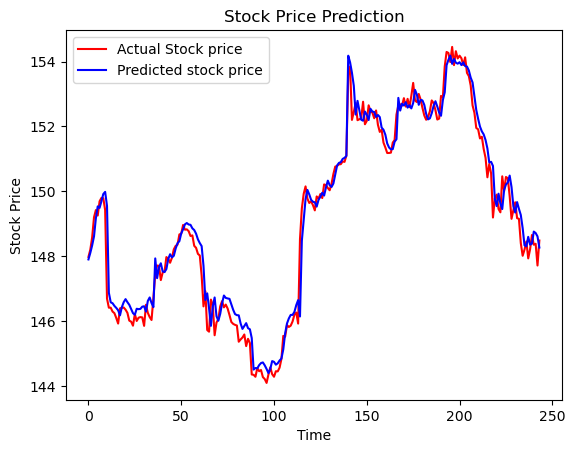

Epoch 1/10
975/975 [==============================] - 28s 21ms/step - loss: 2624.7554 - accuracy: 0.0000e+00
Epoch 2/10
975/975 [==============================] - 21s 22ms/step - loss: 71.4875 - accuracy: 0.0000e+00
Epoch 3/10
975/975 [==============================] - 21s 21ms/step - loss: 9.5226 - accuracy: 0.0000e+00
Epoch 4/10
975/975 [==============================] - 21s 22ms/step - loss: 8.9817 - accuracy: 0.0000e+00
Epoch 5/10
975/975 [==============================] - 22s 23ms/step - loss: 8.7292 - accuracy: 0.0000e+00
Epoch 6/10
975/975 [==============================] - 22s 22ms/step - loss: 6.4106 - accuracy: 0.0000e+00
Epoch 7/10
975/975 [==============================] - 23s 24ms/step - loss: 6.1428 - accuracy: 0.0000e+00
Epoch 8/10
975/975 [==============================] - 29s 30ms/step - loss: 6.2571 - accuracy: 0.0000e+00
Epoch 9/10
975/975 [==============================] - 30s 31ms/step - loss: 5.3942 - accuracy: 0.0000e+00
Epoch 10/10
8/8 [=========================

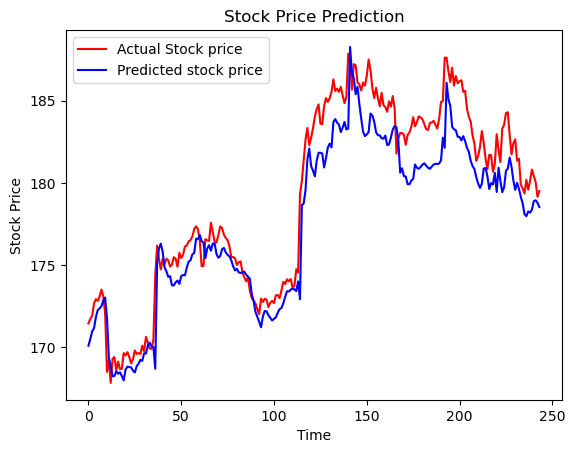

Epoch 1/10
975/975 [==============================] - 36s 29ms/step - loss: 17011.8574 - accuracy: 0.0000e+00
Epoch 2/10
975/975 [==============================] - 29s 30ms/step - loss: 840.7151 - accuracy: 0.0000e+00
Epoch 3/10
975/975 [==============================] - 29s 30ms/step - loss: 692.7375 - accuracy: 0.0000e+00
Epoch 4/10
975/975 [==============================] - 29s 30ms/step - loss: 40.1377 - accuracy: 0.0000e+00
Epoch 5/10
975/975 [==============================] - 29s 29ms/step - loss: 29.1901 - accuracy: 0.0000e+00
Epoch 6/10
975/975 [==============================] - 29s 30ms/step - loss: 25.3500 - accuracy: 0.0000e+00
Epoch 7/10
975/975 [==============================] - 29s 29ms/step - loss: 21.6824 - accuracy: 0.0000e+00
Epoch 8/10
975/975 [==============================] - 27s 28ms/step - loss: 18.1509 - accuracy: 0.0000e+00
Epoch 9/10
975/975 [==============================] - 31s 31ms/step - loss: 17.0032 - accuracy: 0.0000e+00
Epoch 10/10
8/8 [===============

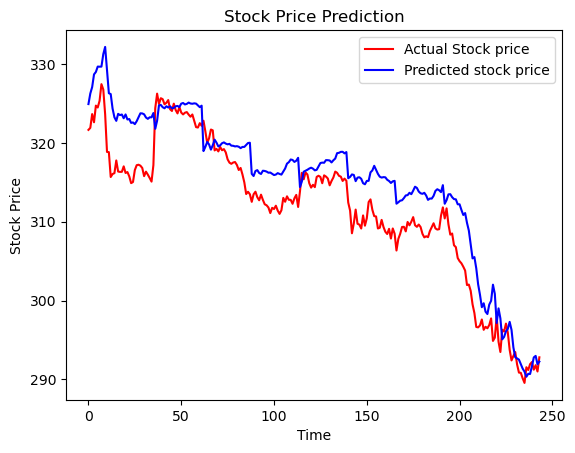

Epoch 1/10
975/975 [==============================] - 26s 20ms/step - loss: 589.8638 - accuracy: 0.0000e+00
Epoch 2/10
975/975 [==============================] - 20s 20ms/step - loss: 56.0463 - accuracy: 0.0000e+00
Epoch 3/10
975/975 [==============================] - 20s 20ms/step - loss: 1.9968 - accuracy: 0.0000e+00
Epoch 8/10
975/975 [==============================] - 19s 20ms/step - loss: 1.2498 - accuracy: 0.0000e+00
Epoch 9/10
975/975 [==============================] - 19s 20ms/step - loss: 1.4889 - accuracy: 0.0000e+00
Epoch 10/10
8/8 [==============================] - 2s 25ms/step
For the AMZN stock the accuracy of the LSTM model is [0.20071856677532196, 0.0]
For the AMZN stock and the LSTM model test mean square error is 0.4480162453785373


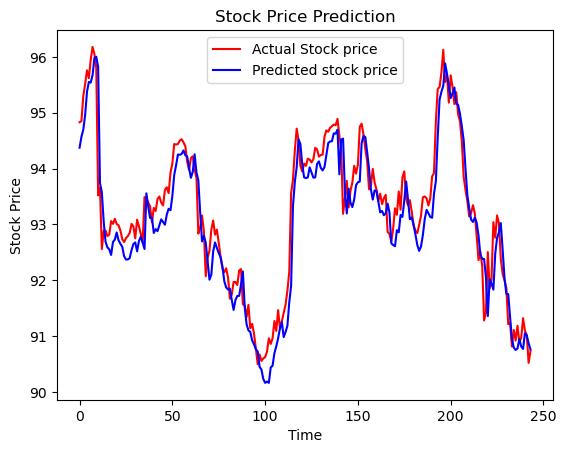

Epoch 1/10
975/975 [==============================] - 31s 22ms/step - loss: 100.7220 - accuracy: 0.0000e+00
Epoch 2/10
975/975 [==============================] - 19s 20ms/step - loss: 0.8622 - accuracy: 0.0000e+00
Epoch 3/10
975/975 [==============================] - 20s 20ms/step - loss: 0.5301 - accuracy: 0.0000e+00
Epoch 4/10
975/975 [==============================] - 20s 20ms/step - loss: 0.3469 - accuracy: 0.0000e+00
Epoch 5/10
975/975 [==============================] - 20s 20ms/step - loss: 0.2920 - accuracy: 0.0000e+00
Epoch 6/10
975/975 [==============================] - 20s 21ms/step - loss: 0.2247 - accuracy: 0.0000e+00
Epoch 7/10
975/975 [==============================] - 19s 20ms/step - loss: 0.1553 - accuracy: 0.0000e+00
Epoch 8/10
975/975 [==============================] - 19s 20ms/step - loss: 0.1559 - accuracy: 0.0000e+00
Epoch 9/10
975/975 [==============================] - 20s 20ms/step - loss: 0.1580 - accuracy: 0.0000e+00
Epoch 10/10
8/8 [===========================

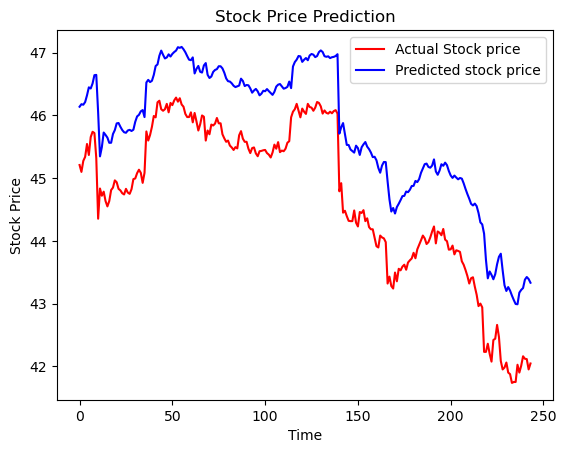

Epoch 1/10
975/975 [==============================] - 27s 20ms/step - loss: 612.3800 - accuracy: 0.0000e+00
Epoch 2/10
975/975 [==============================] - 20s 21ms/step - loss: 25.1343 - accuracy: 0.0000e+00
Epoch 3/10
975/975 [==============================] - 20s 20ms/step - loss: 0.5800 - accuracy: 0.0000e+00
Epoch 8/10
975/975 [==============================] - 19s 20ms/step - loss: 0.6250 - accuracy: 0.0000e+00
Epoch 9/10
975/975 [==============================] - 19s 20ms/step - loss: 0.5770 - accuracy: 0.0000e+00
Epoch 10/10
8/8 [==============================] - 3s 61ms/step
For the GOOGL stock the accuracy of the LSTM model is [1.4850339889526367, 0.0]
For the GOOGL stock and the LSTM model test mean square error is 1.21861967935069


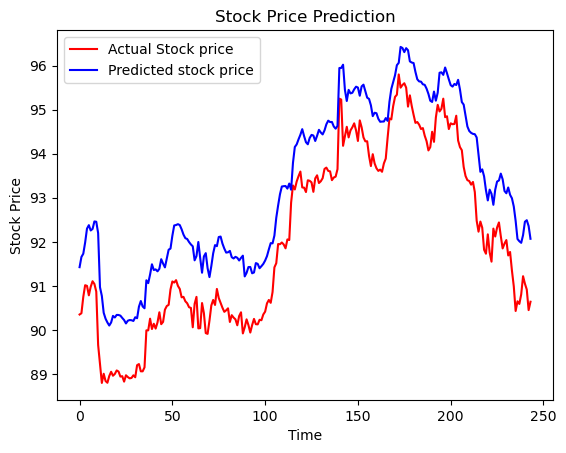

In [38]:
x_columns=[ 'Close_lag1', 'Open_lag1', 'High_lag1', 'Low_lag1', 'Volume_lag1',
   'Close_lag2', 'Open_lag2', 'High_lag2', 'Low_lag2', 'Volume_lag2',
   'Close_lag3', 'Open_lag3', 'High_lag3', 'Low_lag3', 'Volume_lag3',
   'daily_open', 'daily_high', 'daily_low', 'daily_close', 'daily_volume',
   'time_period']
y_columns=['Close']
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    lstm_model(stock=i,x_columns=x_columns,y_columns=y_columns)